In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('data/adult19.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 130.4+ MB


In [4]:
# those that feel depressed at least on a weekly basis
df_depressed = df[df.DEPFREQ_A <= 2].copy()

In [5]:
df_depressed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 12.7+ MB


Introduction: Here, you want to talk about the subject matter domain, an overall take on what makes the topic interesting, and your research questions.

Hypotheses: Given your general research questions, which are based on some interesting observation or outside trend, the next step is to formally state which hypotheses you want to test.

Data: Now that you have walked through the relevance of the topic, posed your research questions, and framed testable hypotheses based on those questions, it's time to introduce the dataset. Tell your audience about the data—when and where was it collected? Perhaps include descriptive statistics or measures of distribution.

Methods: Explain the steps needed to test the hypotheses. This includes any data wrangling, tests, and visualizations that you will need to definitively reject or fail to reject your null hypotheses.

Results: Now, you can walk through the results of the methods. State the results of your tests and explain whether these results mean that you reject or fail to reject the null. Also include compelling tables or graphs to illustrate your findings.

Discussion and recommendations: What insights can interested parties get from this research? What would you recommend for further research?

In [6]:
depressed_vars = pd.read_csv('dep_vars.csv')

In [7]:
depressed_core = df_depressed[depressed_vars.Variable].copy()

In [8]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DEPEV_A     3118 non-null   int64  
 1   DEPFREQ_A   3118 non-null   int64  
 2   DEPMED_A    3118 non-null   int64  
 3   DEPLEVEL_A  3118 non-null   float64
 4   PHQ81_A     3118 non-null   int64  
 5   PHQ82_A     3118 non-null   int64  
 6   PHQ83_A     3118 non-null   int64  
 7   PHQ84_A     3118 non-null   int64  
 8   PHQ85_A     3118 non-null   int64  
 9   PHQ86_A     3118 non-null   int64  
 10  PHQ87_A     3118 non-null   int64  
 11  PHQ88_A     3118 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 316.7 KB


In [9]:
depressed_core.columns

Index(['DEPEV_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'PHQ81_A', 'PHQ82_A',
       'PHQ83_A', 'PHQ84_A', 'PHQ85_A', 'PHQ86_A', 'PHQ87_A', 'PHQ88_A'],
      dtype='object')

According to the codebook, DEPEV_A is the response to the question: "Have you ever been told by a doctor or health professional that you had ...any type of depression?" The values DEPEV_A can take are: 1, yes; 2, no, 7, refused; 8, not ascertained; and 9 , don't know.  Labeling the values and then creating a countplot...  

<AxesSubplot:xlabel='DEPEV_A', ylabel='count'>

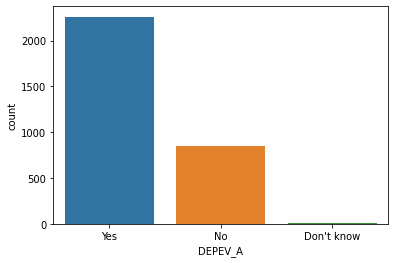

In [10]:
labels = {1:'Yes', 2: 'No', 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
depressed_core.DEPEV_A.replace(labels, inplace=True)
sns.countplot(x = 'DEPEV_A', data = depressed_core)

The majority have been diagnosed as depressed although over 500 have not been told by a doctor they have depression.  
Returning to numerical values, I am going to assign 1 to 'Yes', -1 to 'No' and 0 to 'Don't Know'

In [11]:
labels = {'Yes':1,'No':-1, "Don't know":0}
depressed_core.DEPEV_A.replace(labels, inplace=True)

DEPFREQ_A is the response to the question "How often do you feel depressed?" The values DEPFREQ_A can take are: 1, daily; 2, weekly; 3, monthly; 4, a few times a year; 5 never; 7, refused; 8, not ascertained; 9, don't know.  Earlier I filtered the dataframe to only include values of 1 or 2.  Renaming the labels and creating a countplot... 

<AxesSubplot:xlabel='DEPFREQ_A', ylabel='count'>

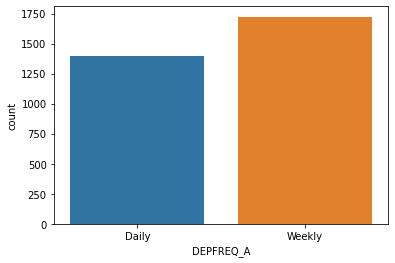

In [12]:
labels = {1:'Daily',2:'Weekly'}
depressed_core.DEPFREQ_A.replace(labels,inplace=True)
sns.countplot(x='DEPFREQ_A', data=depressed_core)

As you can see more feel depression on a weekly basis but it close to even.

As weekly may range from once a week to multiple times a week, I am going to assign the values of 1 to weekly and 5 to daily assuming weekly means one to two times a week.  This is an assumption and so clustering may not be reliable.

In [13]:
labels = {'Daily':5, 'Weekly':1}
depressed_core.DEPFREQ_A.replace(labels, inplace=True)

DEPMED_A represents respondants to the question, "Do you take prescription medication for depression?"  The values are: 1, yes; 2, no; 7, refused; 8, not ascertained; and 9, don't know.

<AxesSubplot:xlabel='DEPMED_A', ylabel='count'>

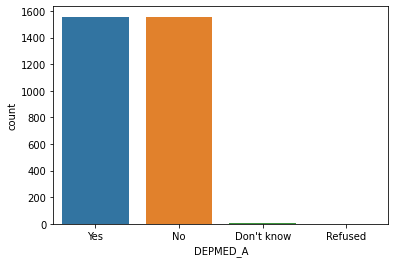

In [14]:
labels = {1:'Yes',2:'No',7:'Refused',8:'Not ascertained',9:"Don't know"}
depressed_core.DEPMED_A.replace(labels,inplace=True)
sns.countplot(x='DEPMED_A',data=depressed_core)

An equal amount of those feeling depression take and do not take medication for depression.  While a miniscule amount do not know or refused to answer.  I am going to assign 1 to yes, -1 to know, and 0 to don't know or refused because both represent uknown values.

In [15]:
labels = {'Yes':1, 'No':-1,"Don't know":0,'Refused':0}
depressed_core.DEPMED_A.replace(labels, inplace=True)

DEPLEVEL_A is the respondants answer to the question, "Thinking about the last time you felt depressed, how depressed did you feel?  Would you say a little, a lot, or somewhere in between?".  Values represented: 1, a little; 2, a lot; 3, somewhere in between a little and a lot; 7, refused; 8, not ascertained; 9, don't know. 

<AxesSubplot:xlabel='DEPLEVEL_A', ylabel='count'>

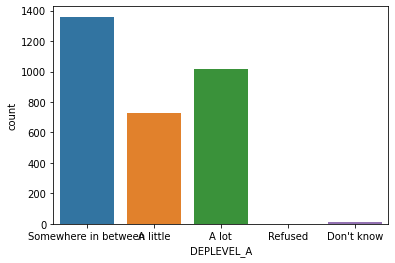

In [16]:
labels = {1: 'A little', 2: 'A lot', 3: 'Somewhere in between', 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
depressed_core.DEPLEVEL_A.replace(labels, inplace=True)
sns.countplot(x = 'DEPLEVEL_A', data = depressed_core)

The majority feel somewhere in between a little and a lot.  Replacing refused or don't know with 0, a little with 1, somewhere in between as 2, and a lot with 3...

In [17]:
labels = {'A little': 1, 'A lot' : 3, 'Somewhere in between': 2, 'Refused': 0, "Don't know" : 0}
depressed_core.DEPLEVEL_A.replace(labels, inplace=True)

PHQ81_A holds responses from the question, "Over the last two weeks how often have you been bothered by little interest or pleasure in doing things?" Responses include: 1, not at all; 2, several days; 3, more than half the days; 4, nearly every day; 7, refused; 8, not ascertained; 9, don't know.

<AxesSubplot:xlabel='PHQ81_A', ylabel='count'>

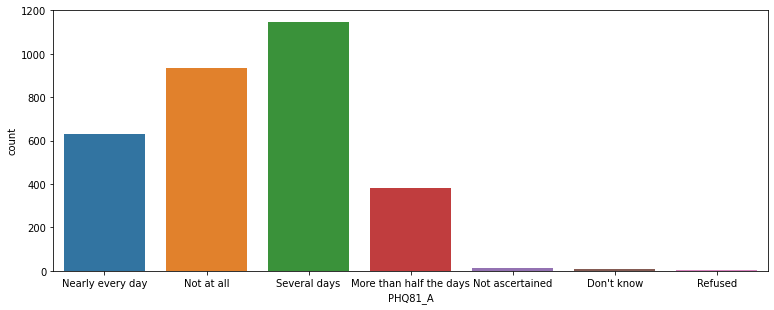

In [18]:
labels = {1: 'Not at all', 2: 'Several days', 3: 'More than half the days', 4: 'Nearly every day', 7: 'Refused', 
          8: 'Not ascertained', 9: "Don't know"}
depressed_core.PHQ81_A.replace(labels, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ81_A', data=depressed_core)

The majority of those facing depression feels bothered by little interest or pleasure several days.  I am going to give nearly every day a value of 12, not at all a value of 0, more than half the days a value of 8, several days a value of 4, and the not ascertained, don't know, and refused a value of np.nan

In [19]:
labels = {'Nearly every day':12,'Not at all':0, 'Several days':4, 'More than half the days':8, 'Not ascertained':np.NAN, 
          "Don't know": np.NAN, 'Refused':np.NAN}
depressed_core.PHQ81_A.replace(labels, inplace=True)

PHQ82_A holds the answer to: in the past two weeks, how often have you been bothered by feeling down, depressed or hopeless?
The data can take on values: 1, not at all; 2, several days; 3, more than half the days; 4, nearly every day; 7, refused; 8, not ascertained; or 9, don't know.

<AxesSubplot:xlabel='PHQ82_A', ylabel='count'>

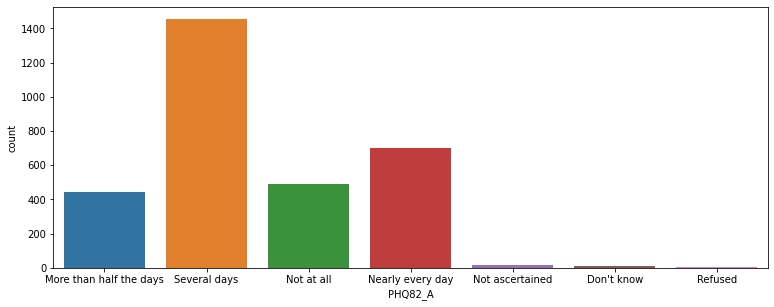

In [20]:
labels_ntostr = {1: 'Not at all', 2: 'Several days', 3: 'More than half the days', 4: 'Nearly every day', 7: 'Refused', 
          8: 'Not ascertained', 9: "Don't know"}
labels_strton = {'Nearly every day':12,'Not at all':0, 'Several days':4, 'More than half the days':8, 'Not ascertained':np.NAN, 
          "Don't know": np.NAN, 'Refused':np.NAN}
depressed_core.PHQ82_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ82_A', data=depressed_core)

Again most felt down several days.  Like the last question, I am replacing not at all with 0, several days with 4, more than half the days with 8, nearly every day with 12 and the rest with NAN

In [21]:
depressed_core.PHQ82_A.replace(labels_strton, inplace=True)

PHQ83_A indicates how often in the past two weeks people have been bothered by trouble falling asleep, trouble staying aslepp, or sleeping too much.

<AxesSubplot:xlabel='PHQ83_A', ylabel='count'>

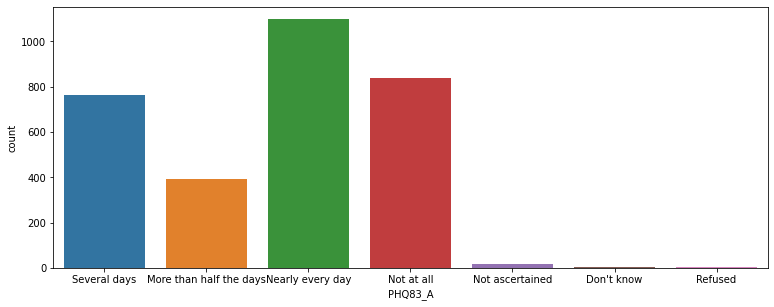

In [22]:
depressed_core.PHQ83_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ83_A', data=depressed_core)

In this case the majority of those with depression have been feeling bothered by trouble with sleep nearly every day

In [23]:
depressed_core.PHQ83_A.replace(labels_strton, inplace=True)

PHQ84_A records responses to the question on over the past two weeks how often have you been bothered by feeling tired or having little energy.

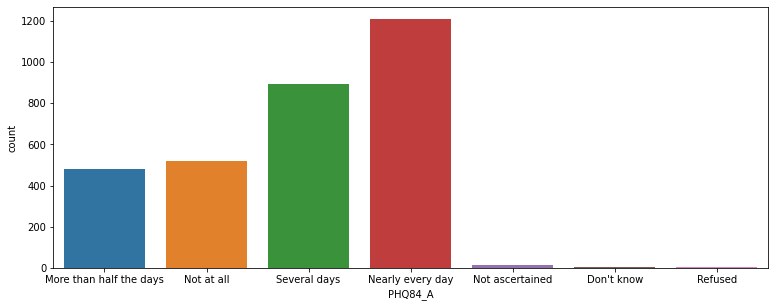

In [24]:
depressed_core.PHQ84_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ84_A', data=depressed_core)
depressed_core.PHQ84_A.replace(labels_strton, inplace=True)

Notice most have trouble with energy levels nearly every day.


PHQ85_A reports how many times in the past two weeks have people been bothered by a poor appetite or overeating.

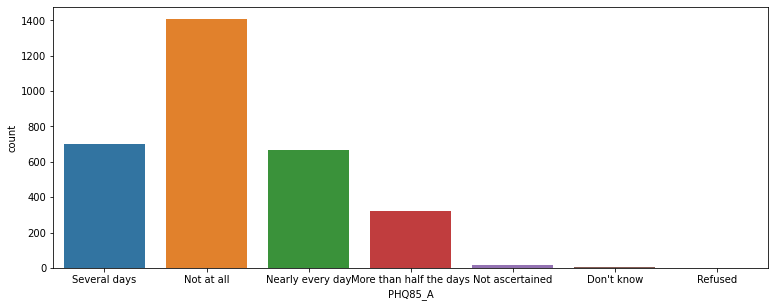

In [25]:
depressed_core.PHQ85_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ85_A', data=depressed_core)
depressed_core.PHQ85_A.replace(labels_strton, inplace=True)

The majority were not at all bothered by over or under eating.

PHQ86_A reports how many times over the past two weeks, people have been bothered by feeling bad about themselves.

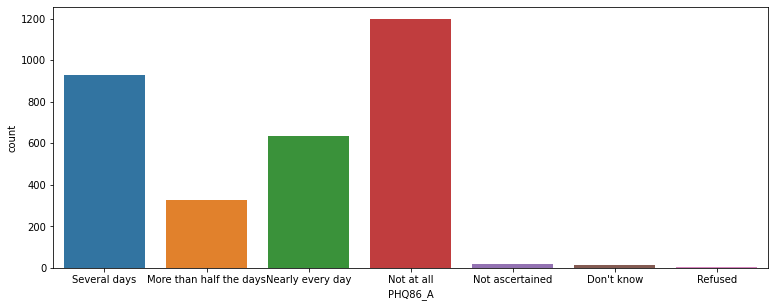

In [26]:
depressed_core.PHQ86_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ86_A', data=depressed_core)
depressed_core.PHQ86_A.replace(labels_strton, inplace=True)

As can be seen there is a split between several days or not at all.

PHQ87_A reports how many times over the past few weeks people have been bothered by trouble concentrating

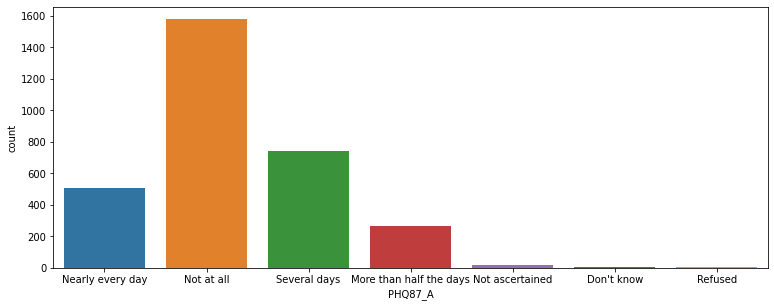

In [27]:
depressed_core.PHQ87_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ87_A', data=depressed_core)
depressed_core.PHQ87_A.replace(labels_strton, inplace=True)

Most were not bothered by trouble concentrating

PHQ88_A asks how often in the past few weeks people were bothered by moving or speaking slow or fast.

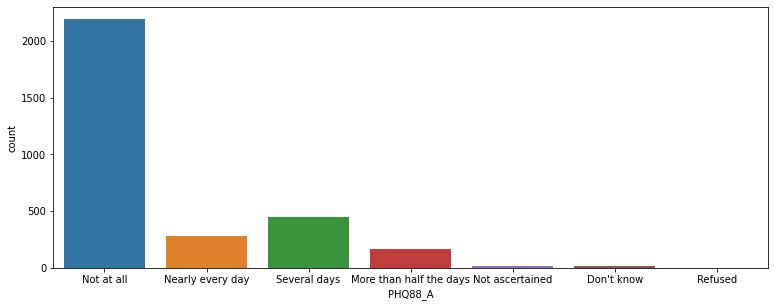

In [28]:
depressed_core.PHQ88_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ88_A', data=depressed_core)
depressed_core.PHQ88_A.replace(labels_strton, inplace=True)

The clear majority is not at all

In [29]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DEPEV_A     3118 non-null   int64  
 1   DEPFREQ_A   3118 non-null   int64  
 2   DEPMED_A    3118 non-null   int64  
 3   DEPLEVEL_A  3118 non-null   int64  
 4   PHQ81_A     3090 non-null   float64
 5   PHQ82_A     3089 non-null   float64
 6   PHQ83_A     3094 non-null   float64
 7   PHQ84_A     3096 non-null   float64
 8   PHQ85_A     3096 non-null   float64
 9   PHQ86_A     3083 non-null   float64
 10  PHQ87_A     3092 non-null   float64
 11  PHQ88_A     3082 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 381.2 KB


In [31]:
depressed_core.isnull().sum()

DEPEV_A        0
DEPFREQ_A      0
DEPMED_A       0
DEPLEVEL_A     0
PHQ81_A       28
PHQ82_A       29
PHQ83_A       24
PHQ84_A       22
PHQ85_A       22
PHQ86_A       35
PHQ87_A       26
PHQ88_A       36
dtype: int64

There are a small amount of null values, these will be dropped.

In [32]:
depressed_core.dropna(inplace=True)

In [33]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3047 entries, 4 to 31990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DEPEV_A     3047 non-null   int64  
 1   DEPFREQ_A   3047 non-null   int64  
 2   DEPMED_A    3047 non-null   int64  
 3   DEPLEVEL_A  3047 non-null   int64  
 4   PHQ81_A     3047 non-null   float64
 5   PHQ82_A     3047 non-null   float64
 6   PHQ83_A     3047 non-null   float64
 7   PHQ84_A     3047 non-null   float64
 8   PHQ85_A     3047 non-null   float64
 9   PHQ86_A     3047 non-null   float64
 10  PHQ87_A     3047 non-null   float64
 11  PHQ88_A     3047 non-null   float64
dtypes: float64(8), int64(4)
memory usage: 309.5 KB


#  Visualizing the data using PCA and UMAP

Text(0.5, 1.0, 'UMAP')

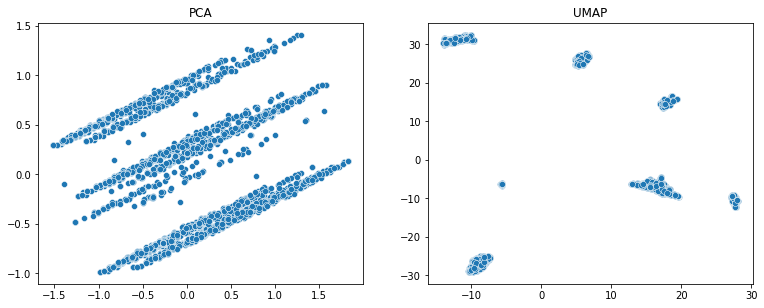

In [35]:
scaler = MinMaxScaler()
X = scaler.fit_transform(depressed_core)
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

Clustering is definitely seen.  The number of clusters appears to be 3 or more, although nothing can be inferred.  

# Kmeans

<AxesSubplot:>

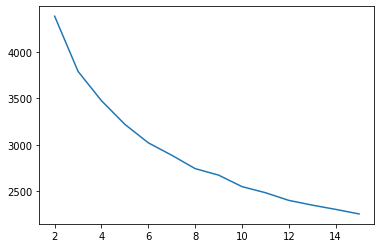

In [37]:
inertia_values = []
for n in range(2,16):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))

sns.lineplot(x=results[0],y=results[1])

Going to look at the number of clusters being 3, 6, and 8 and seeing which produces the greatest silhouette score.

In [41]:
for n in [3,6,8]:
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    print("The silhouette score for {} clusters is {}".format(n,silhouette_score(X,preds)))

The silhouette score for 3 clusters is 0.18394183377376486
The silhouette score for 6 clusters is 0.18140626376069457
The silhouette score for 8 clusters is 0.18721533543150473


The silhouette score seems best for 8 clusters.  Although it is still low.  

Looking at visualizations

Text(0.5, 1.0, 'UMAP')

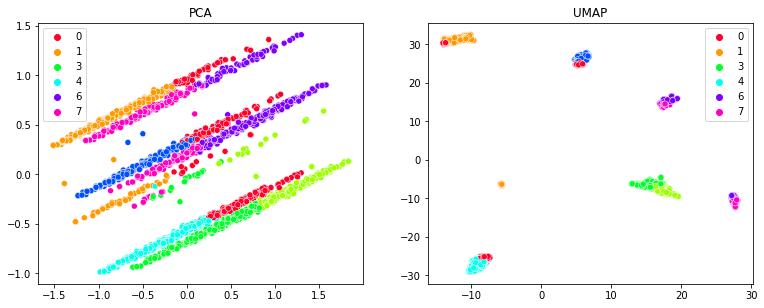

In [42]:
kmeans=KMeans(n_clusters=8)
preds = kmeans.fit_predict(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], hue = preds, palette='gist_rainbow', ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], hue = preds, palette='gist_rainbow', ax=axs[1])
axs[1].set_title('UMAP')

As can be seen, clusters are mixing.  KMeans may not be the best way to cluster data.  

# DBSCAN

In [43]:
db = DBSCAN()
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()))

The number of clusters selected by DBSCAN is 23


In [44]:
print("The silhouette score for DBSCAN is {}".format(silhouette_score(X[preds!=-1],preds[preds!=-1])))

The silhouette score for DBSCAN is 0.10871629350022508


The silhouette score is lower than kmeans.  

play with hyperparameter tuning to see if you can get this higher.

# Hierarchal clustering

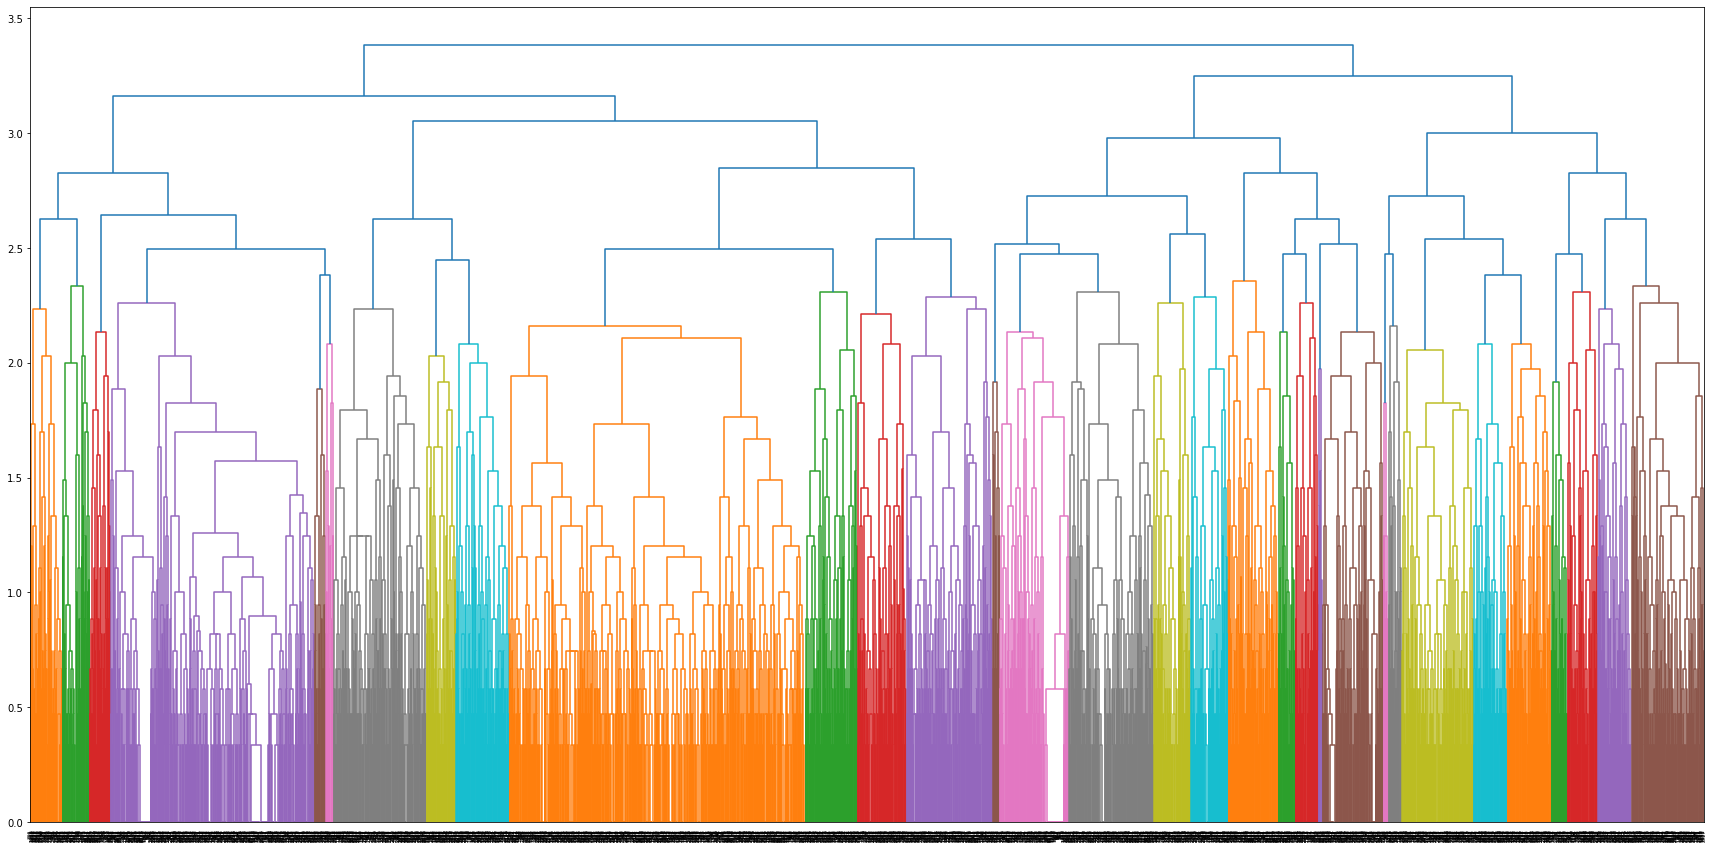

In [47]:
plt.figure(figsize=(30,15))
dendrogram(linkage(X, method='complete'))
plt.show()

As can be scene there is great variety of cluster, some large clusters, other small clusters.